## Changing the regulatory logic of the promoter

Required packages:

In [1]:
# processing
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt

fdir = '../data/'
out_fdir = '../plots/fig8/'

### 0. Loading input data

Same as in the notebook `fig3_architecture.ipynb`, we first load the required promoter sequence and energy matrices.

In [2]:
_genome = []
for record in SeqIO.parse(fdir + "mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

df = pd.read_csv(fdir + 'ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

We manually specify the binding site sequences. Note that these sequences all need to be contained within the promoter sequence itself.

In [3]:
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'
rep_site = 'AATTGTGAGCGGATAACAATT'

We read in the known energy matrix for RNA polymerase. This energy matrix is experimentally determined and shown in Figure 2 of Brewster et al., 2012. (https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002). We use the function `fix_wt` from the `tregs` package to normalize the energy matrix such that the wild type base identities correspond to a binding energy of $0\ k_BT$.

In [4]:
rnap_emat_raw = np.loadtxt(fdir + 'energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

The energy matrices for the two repressors are randomly generated using the `generate_emap` function

In [5]:
rep1_site = promoter[(115):(115+10)]
rep2_site = promoter[(115+20):(115+30)]

r1_emat = tregs.simulate.generate_emap(rep1_site, fixed=True, fixed_value=1)
r2_emat = tregs.simulate.generate_emap(rep2_site, fixed=True, fixed_value=1)

### 1.1 Average mutual information as a function of repressor copy number for a double repression promoter with AND or OR regulatory logic

For each repressor copy number, we simulate 200 synthetic datasets in order to observe the average effects. To save computational time, we first generate 200 mutant libraries beforehand using the function `mutations_rand`.

In [6]:
num_mutants = 200

mutant_bank = []
for i in range(num_mutants):
    mutants = np.unique(tregs.wgregseq.mutations_rand(promoter,
                                                rate=0.1,
                                                num_mutants=5000,
                                                number_fixed=True,
                                                keep_wildtype=True))
    mutant_bank.append(mutants)

We specify the usual parameters needed for a double repression thermodynamic model and the range of copy number for the first repressor.

In [7]:
n_NS = len(genome)
ep_wt, er1_wt, er2_wt = -5, -14, -14
e_int = -5
n_p, n_r2 = 5000, 25

l_n_r1 = np.arange(0, 50, 2)

We first simulate synthetic datasets for a double repression promoter under the AND regulatory logic and keep track of the average mutual information at the two repressor binding sites for each of the pre-generated mutant libraries at each copy number

In [8]:
r1_AND = np.zeros((len(l_n_r1), num_mutants))
r2_AND = np.zeros((len(l_n_r1), num_mutants))

for i, n_r1 in enumerate(l_n_r1):
    for j in range(num_mutants):
        df = tregs.simulate.sim(promoter, tregs.simulate.doublerep_pbound,
                                [rnap_site, rep1_site, rep2_site],
                                *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat,
                                  ep_wt, er1_wt, er2_wt, e_int, 'AND'],
                                preset_mutants=mutant_bank[j],
                                scaling_factor=10**6)

        mut_list = df['seq'].values
        mu_data = df['norm_ct_1']
        nbins = 2
        upper_bound = np.median(mu_data)

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                    pseudocount=10**(-6))
        r1_AND[i, j] = np.mean(footprint[(115):(115+10)])
        r2_AND[i, j] = np.mean(footprint[(115+20):(115+30)])    

Next, we repeat the process for a double repression promoter under the OR regulatory logic.

In [9]:
r1_OR = np.zeros((len(l_n_r1), num_mutants))
r2_OR = np.zeros((len(l_n_r1), num_mutants))

for i, n_r1 in enumerate(l_n_r1):
    for j in range(num_mutants):
        df = tregs.simulate.sim(promoter, tregs.simulate.doublerep_pbound,
                                [rnap_site, rep1_site, rep2_site],
                                *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat,
                                  ep_wt, er1_wt, er2_wt, e_int, 'OR'],
                                preset_mutants=mutant_bank[j],
                                scaling_factor=10**6)

        mut_list = df['seq'].values
        mu_data = df['norm_ct_1']
        nbins = 2
        upper_bound = np.median(mu_data)

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                    pseudocount=10**(-6))
        r1_OR[i, j] = np.mean(footprint[(115):(115+10)])
        r2_OR[i, j] = np.mean(footprint[(115+20):(115+30)])

We plot the average mutual information against the copy number of the first repressor for double repression promoters under the AND logic and under the OR logic.

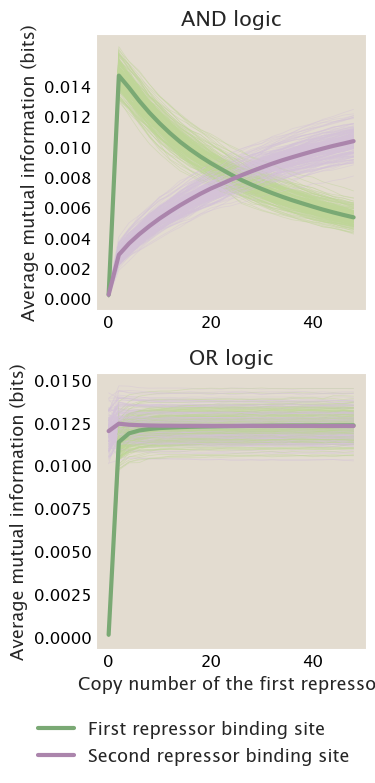

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(4,8))
ax1, ax2 = axes

for i in range(num_mutants):
    ax1.plot(l_n_r1, np.asarray(r1_AND)[:, i], color='#BFD598', alpha=0.5, linewidth=0.5)
    ax1.plot(l_n_r1, np.asarray(r2_AND)[:, i], color='#D4C2D9', alpha=0.5, linewidth=0.5)
ax1.plot(l_n_r1, np.mean(r1_AND, axis=1), label='First repressor binding site', color='#7AA974', linewidth=3)
ax1.plot(l_n_r1, np.mean(r2_AND, axis=1), label='Second repressor binding site', color='#AB85AC', linewidth=3)
ax1.set_ylabel('Average mutual information (bits)', fontsize=13)
ax1.set_title('AND logic', fontsize=15)
ax1.set_yticks(np.arange(0, 0.015, 0.002))

for i in range(num_mutants):
    ax2.plot(l_n_r1, np.asarray(r1_OR)[:, i], color='#BFD598', alpha=0.5, linewidth=0.5)
    ax2.plot(l_n_r1, np.asarray(r2_OR)[:, i], color='#D4C2D9', alpha=0.5, linewidth=0.5)
ax2.plot(l_n_r1, np.mean(r1_OR, axis=1), label='First repressor binding site', color='#7AA974', linewidth=3)
ax2.plot(l_n_r1, np.mean(r2_OR, axis=1), label='Second repressor binding site', color='#AB85AC', linewidth=3)
ax2.set_xlabel('Copy number of the first repressor', fontsize=13)
ax2.set_ylabel('Average mutual information (bits)', fontsize=13)
ax2.set_title('OR logic', fontsize=15)
#ax2.set_ylim(0.008, 0.013)
ax2.legend(bbox_to_anchor=(1, -0.2), frameon=False, fontsize=13)

plt.tight_layout()
plt.savefig(out_fdir + 'figR7.pdf', dpi=300)

### 1.2 Representative information footprints of a double repression promoter under AND and OR logic

We plot representative information footprints at three different repressor copy numbers for the AND and OR double repression repressors. 

**1.2.1 AND logic**

Below is an information footprint with 0 copies of the first repressor (mimicking the effect when the first repressor is knocked out) for a double repression promoter with AND logic.

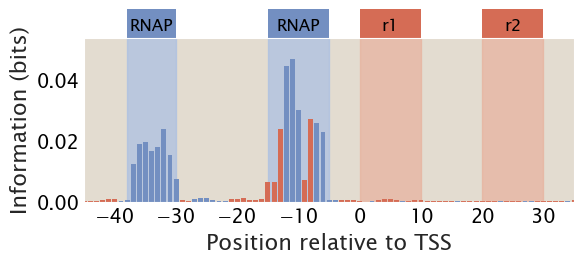

In [12]:
n_r1 = 0

df = tregs.simulate.sim(promoter, tregs.simulate.doublerep_pbound, [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, 'AND'],
                        scaling_factor=10**6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (0, 10, 'R', 'r1'), (20, 30, 'R', 'r2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 35), fig_width=6,
                               outfile=out_fdir + 'knockout_doublerep_AND_fp1.pdf')

Below we plot an information footprint with 5 copies of the first repressor for a double repression promoter with AND logic.

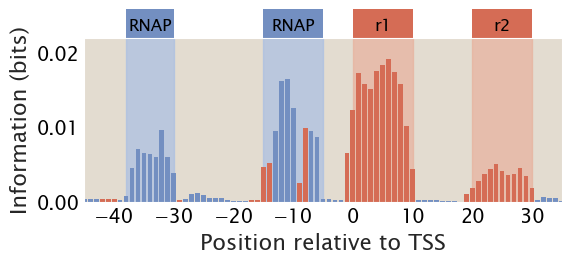

In [13]:
n_r1 = 5

df = tregs.simulate.sim(promoter, tregs.simulate.doublerep_pbound, [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, 'AND'],
                        scaling_factor=10**6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (0, 10, 'R', 'r1'), (20, 30, 'R', 'r2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 35), fig_width=6,
                               outfile=out_fdir + 'knockout_doublerep_AND_fp2.pdf')

Below we plot an information footprint with 50 copies of the first repressor for a double repression promoter with AND logic.

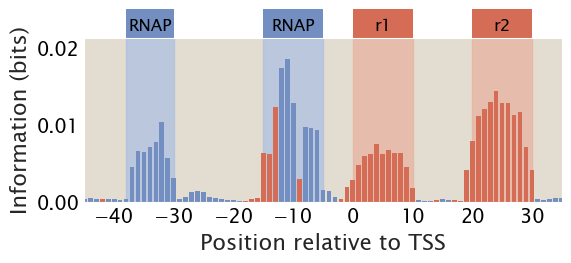

In [14]:
n_r1 = 50

df = tregs.simulate.sim(promoter, tregs.simulate.doublerep_pbound, [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, 'AND'],
                        scaling_factor=10**6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (0, 10, 'R', 'r1'), (20, 30, 'R', 'r2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 35), fig_width=6,
                               outfile=out_fdir + 'knockout_doublerep_AND_fp3.pdf')

**1.2.2 OR logic**

Below is an information footprint with 0 copies of the first repressor for a double repression promoter with OR logic.

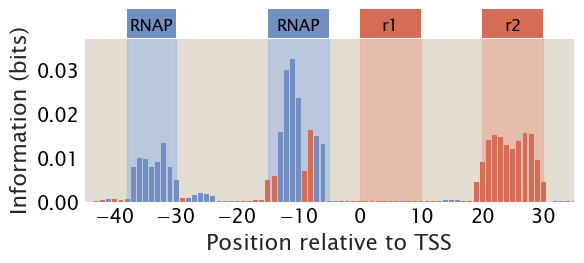

In [15]:
n_r1 = 0

df = tregs.simulate.sim(promoter, tregs.simulate.doublerep_pbound, [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, 'OR'],
                        scaling_factor=10**6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (0, 10, 'R', 'r1'), (20, 30, 'R', 'r2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 35), fig_width=6,
                               outfile=out_fdir + 'knockout_doublerep_OR_fp1.pdf')

Below is an information footprint with 5 copies of the first repressor for a double repression promoter with OR logic.

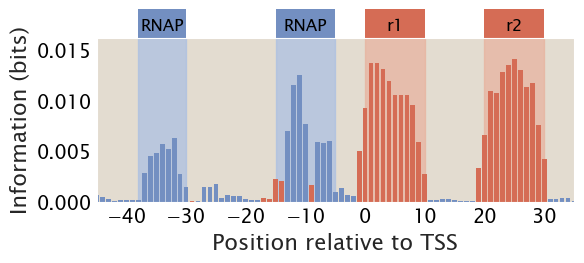

In [16]:
n_r1 = 5

df = tregs.simulate.sim(promoter, tregs.simulate.doublerep_pbound, [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, 'OR'],
                        scaling_factor=10**6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (0, 10, 'R', 'r1'), (20, 30, 'R', 'r2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 35), fig_width=6,
                               outfile=out_fdir + 'knockout_doublerep_OR_fp2.pdf')

Below we plot an information footprint with 50 copies of the first repressor for a double repression promoter with OR logic.

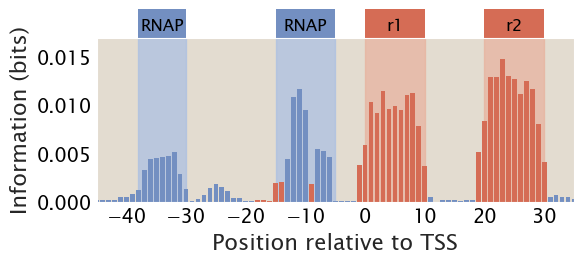

In [17]:
n_r1 = 50

df = tregs.simulate.sim(promoter, tregs.simulate.doublerep_pbound, [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, 'OR'],
                        scaling_factor=10**6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (0, 10, 'R', 'r1'), (20, 30, 'R', 'r2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 35), fig_width=6,
                               outfile=out_fdir + 'knockout_doublerep_OR_fp3.pdf')